In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import copy
import tensorflow as tf

import os
import time
import numpy as np
from IPython.display import clear_output
import sys
import csv
import math
from matplotlib import colors
import fcn32_freez as fcn32_vgg
import csv


ckpt_dir = "/mnt/data3/exp2/layer2/fcn32_layer2.ckpt"

PRETRAINED_MODEL_PATH= None #"/mnt/data3/exp2/layer2"

WEIGHT_PATH = "/mnt/data1/imagenet-data/weights/vgg-epoch-78.npy"

TRAINSET_PATH = "/home/sik4hi/city/csv_files/cityscapes_train_wmask.csv"
VALSET_PATH = "/home/sik4hi/city/csv_files/cityscapes_val_wmask.csv"

data_csv_path = 'fcn32-layer2.csv'


NUM_OF_CLASSESS = 19
BATCH_SIZE = 1
IMAGE_HEIGHT = 1024
IMAGE_WIDTH = 2048
NUM_CHANNELS = 3
N_EPOCHS = 300

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
train_csv_file=open(TRAINSET_PATH,"r")
train_filepaths=[]
train_labels=[]
train_masks=[]
for line in train_csv_file:
    filepath, label, mask= line.split(",")
    train_filepaths.append(filepath)
    train_labels.append(label)
    train_masks.append(mask.split("\r")[0])
    
train_image_path, train_label_path, train_mask_path = tf.train.slice_input_producer([train_filepaths,train_labels, train_masks]
                                           ,capacity = 2975)
#csv_path = tf.train.string_input_producer([TRAINSET_PATH])
#textReader = tf.TextLineReader()
#_, content = textReader.read(csv_path)
#one_ex = tf.decode_csv(content, record_defaults=[[""], [""], [""]])

train_image_content = tf.read_file(train_image_path)
train_image = tf.image.decode_png(train_image_content, channels=3)
train_image.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS])
train_image = tf.cast(train_image, tf.float32)

train_label_content = tf.read_file(train_label_path)
train_label = tf.image.decode_png(train_label_content, channels=1)
train_label.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, 1])
train_label=tf.squeeze(train_label, squeeze_dims=[2])

#record_bytes=2097152
#reader=tf.FixedLengthRecordReader(record_bytes)
train_mask_content =tf.read_file(train_mask_path)
train_mask=tf.decode_raw(train_mask_content,tf.uint8)
train_mask.set_shape([2097152])
#mask=tf.cast(mask, tf.float32)


val_csv_file=open(VALSET_PATH,"r")
val_filepaths=[]
val_labels=[]
val_masks=[]
for line in val_csv_file:
    filepath, label, mask= line.split(",")
    val_filepaths.append(filepath)
    val_labels.append(label)
    val_masks.append(mask.split("\r")[0])
    
val_image_path, val_label_path, val_mask_path = tf.train.slice_input_producer([val_filepaths,val_labels, val_masks]
                                           ,capacity = 500)
#csv_path = tf.train.string_input_producer([TRAINSET_PATH])
#textReader = tf.TextLineReader()
#_, content = textReader.read(csv_path)
#one_ex = tf.decode_csv(content, record_defaults=[[""], [""], [""]])

val_image_content = tf.read_file(val_image_path)
val_image = tf.image.decode_png(val_image_content, channels=3)
val_image.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS])
val_image = tf.cast(val_image, tf.float32)

val_label_content = tf.read_file(val_label_path)
val_label = tf.image.decode_png(val_label_content, channels=1)
val_label.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, 1])
val_label=tf.squeeze(val_label, squeeze_dims=[2])

#record_bytes=2097152
#reader=tf.FixedLengthRecordReader(record_bytes)
val_mask_content =tf.read_file(val_mask_path)
val_mask=tf.decode_raw(val_mask_content,tf.uint8)
val_mask.set_shape([2097152])
#mask=tf.cast(mask, tf.float32)



train_image_batch, train_label_batch, train_mask_batch= tf.train.batch([train_image, train_label, train_mask], batch_size=BATCH_SIZE,
                                                               capacity=100 + 3 * BATCH_SIZE,
                                                               num_threads=7)

val_image_batch, val_label_batch, val_mask_batch= tf.train.batch([val_image, val_label, val_mask], batch_size=BATCH_SIZE,
                                                               capacity=50 + 3 * BATCH_SIZE,
                                                               num_threads=7)

with tf.device('/gpu:0'):
    sess = tf.Session()
    #images_tf = tf.placeholder(tf.float32,[None, 1024, 2048, 3])
    #labels_tf = tf.placeholder(tf.int32,[None, 1024, 2048])
    #masks_tf = tf.placeholder(tf.float32,[None,2097152])
    train_mode = tf.placeholder(tf.bool)
    
    vgg_fcn = fcn32_vgg.FCN32VGG(WEIGHT_PATH)#('./vgg16.npy')
    
    if train_mode is not None:
        images_tf=tf.cond(train_mode, lambda:train_image_batch, lambda:val_image_batch)
    if train_mode is not None:
        labels_tf=tf.cond(train_mode, lambda:train_label_batch, lambda:val_label_batch)
    if train_mode is not None:
        masks_tf=tf.cond(train_mode, lambda:train_mask_batch, lambda:val_mask_batch)
    
    freez=[ True,True,
        False,False,
        False,False,False,
        False,False,False,
        False,False,False]
    
    with tf.name_scope("content_vgg"):
        vgg_fcn.build(images_tf, freez=freez , train=train_mode, num_classes=19, random_init_fc8=True, debug=False)


    #head=[]
    #sum_of_weights=tf.reduce_sum(weights)
    #labels_oh= tf.one_hot(labels_tf,19)
    
    labels_tf_flat=tf.reshape(tf.mul(tf.reshape(labels_tf,[-1]),masks_tf),[-1])
    #mask_reshped=tf.reshape(masks_tf,[1024,2048])
    #labels_tf_flat2= tf.gather(labels_tf_flat,tf.where(tf.not_equal(labels_tf_flat,19))[1])
    logits = tf.reshape(vgg_fcn.upscore, (-1, NUM_OF_CLASSESS))
    #logits = tf.gather(logits,tf.where(tf.not_equal(labels_tf_flat,19)))
    labels_tf_flat = tf.cast(labels_tf_flat, tf.int32)

    #epsilon = tf.constant(value=1e-4)
    #logits = logits + epsilon
    #labels_flat_sparse = tf.reshape(labels_oh, (-1, NUM_OF_CLASSESS))
    #labels_flat_sparse=tf.cast(labels_flat_sparse, tf.float64)
    #ww_flat=tf.reshape(weights,[-1])
    #ww_flat = tf.cast(ww_flat, tf.float64)
    #softmax = tf.nn.softmax(logits)
    #softmax = tf.cast(softmax, tf.float64)
    #test1=-tf.reduce_sum(labels_flat_sparse * tf.log(softmax), reduction_indices=[1])
    #test2=tf.reduce_sum(test1)
    #cross_entropy = tf.mul(-tf.reduce_sum(labels_flat_sparse * tf.log(softmax), reduction_indices=[1]),ww_flat)
    #cross_entropy = -tf.reduce_sum(labels_flat_sparse * tf.log(softmax), reduction_indices=[1])
    #mask_flat=tf.reshape(train_mask_batch,[-1])
    masks_tf=tf.cast(masks_tf, tf.float32)
    cross_entropy =tf.mul(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,labels_tf_flat),masks_tf)
    #cross_entropy_sum= tf.reduce_sum(cross_entropy,
    #                                name='xentropy_mean')
    #cross_entropy_mean = tf.reduce_mean(cross_entropy,name='xentropy_mean')
    #cross_entropy_mean = cross_entropy_sum/tf.cast(sum_of_weights, tf.float32)
    cross_entropy_mean = tf.reduce_mean(cross_entropy,
                                        name='xentropy_mean')
    l2_loss=tf.reduce_sum(tf.get_collection("losses"))
    total_loss=cross_entropy_mean +l2_loss
    #loss_tf = tf.reduce_mean((tf.nn.sparse_softmax_cross_entropy_with_logits(vgg_fcn.upscore,
     #                                                                     tf.squeeze(labels_tf, squeeze_dims=[3]),
      #                                                                    name="entropy")))
    
    
    
    
    #train_op = tf.train.MomentumOptimizer(0.0001, 0.99).minimize(cross_entropy_mean)
    train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_mean)
    predictions=tf.argmax(logits, 1)
    #labels_tf_flat=tf.reshape(labels_tf_flat,[-1])
    #labels_flat=tf.cast(labels_tf_flat, tf.int64)
    pred_flat=tf.reshape(predictions,[-1])
with tf.device('/cpu:0'):
    miou,update_cm=tf.contrib.metrics.streaming_mean_iou(pred_flat,labels_tf_flat,19,weights=masks_tf)
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    saver = tf.train.Saver(max_to_keep=150)
with tf.device('/gpu:0'):
    print('Finished building Network.')
    
    init_op = tf.group(tf.initialize_all_variables(),
                       tf.initialize_local_variables())
    sess.run(init_op)
        
    if PRETRAINED_MODEL_PATH:
        print "using Pretrained model"
        ckpt = tf.train.get_checkpoint_state(PRETRAINED_MODEL_PATH)
        print(ckpt)
        saver.restore(sess,ckpt.model_checkpoint_path)
        
    # print(csv_path)
    # For populating queues with batches, very important!
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    
    print("finished")

Model Loaded
conv1_1 Value Loaded
Layer name: conv1_1
Layer shape: (3, 3, 3, 64)
conv1_1 Frozen
conv1_1bias Frozen
conv1_1 (64,) Value Loaded


conv1_2 Value Loaded
Layer name: conv1_2
Layer shape: (3, 3, 64, 64)
conv1_2 Frozen
conv1_2bias Frozen
conv1_2 (64,) Value Loaded


conv2_1 Value Loaded
Layer name: conv2_1
Layer shape: (3, 3, 64, 128)
L2 Loss Added
conv2_1 (128,) Value Loaded


conv2_2 Value Loaded
Layer name: conv2_2
Layer shape: (3, 3, 128, 128)
L2 Loss Added
conv2_2 (128,) Value Loaded


conv3_1 Value Loaded
Layer name: conv3_1
Layer shape: (3, 3, 128, 256)
L2 Loss Added
conv3_1 (256,) Value Loaded


conv3_2 Value Loaded
Layer name: conv3_2
Layer shape: (3, 3, 256, 256)
L2 Loss Added
conv3_2 (256,) Value Loaded


conv3_3 Value Loaded
Layer name: conv3_3
Layer shape: (3, 3, 256, 256)
L2 Loss Added
conv3_3 (256,) Value Loaded


conv4_1 Value Loaded
Layer name: conv4_1
Layer shape: (3, 3, 256, 512)
L2 Loss Added
conv4_1 (512,) Value Loaded


conv4_2 Value Loaded
Layer name: co

In [2]:
epoch = 0

Epoch 76
===========**Training ACCURACY**================
Training mIOU:  0.884626
Training Loss: 0.0437093
Training Loss: 7.31925
===========**VALIDATION ACCURACY**================
Validation mIOU:  0.635496
Validation Loss: 0.312432
=================**TIME**====================
Time Elapsed for Epoch:76 is 45.9945886334 minutes


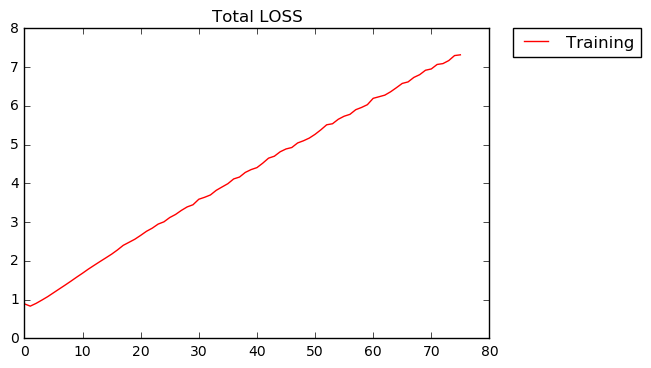

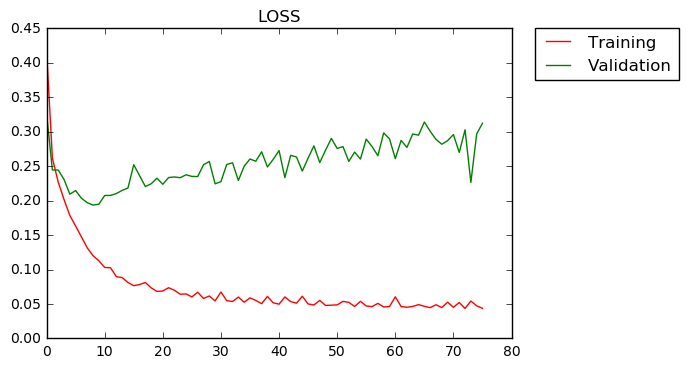

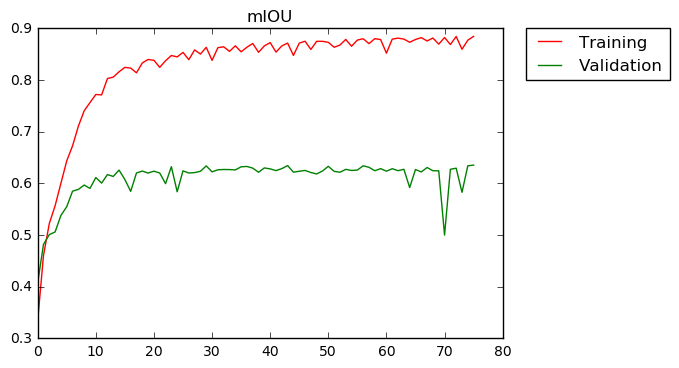

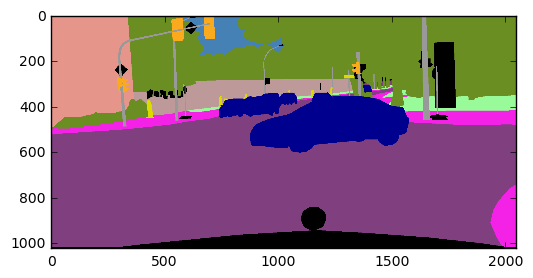

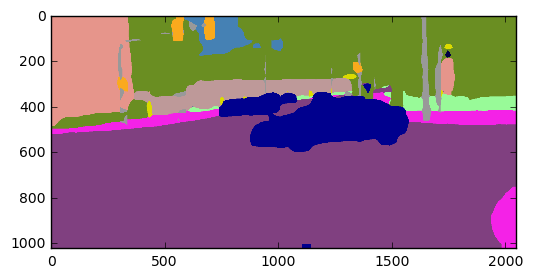

499

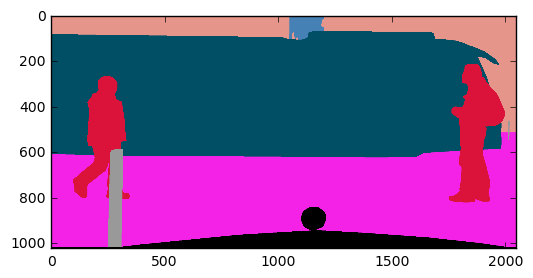

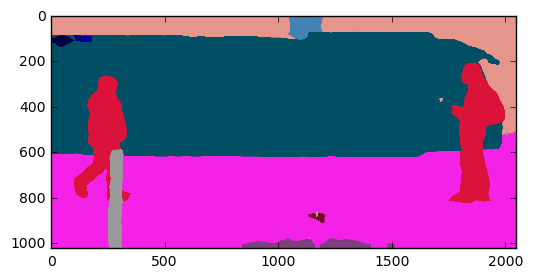

999

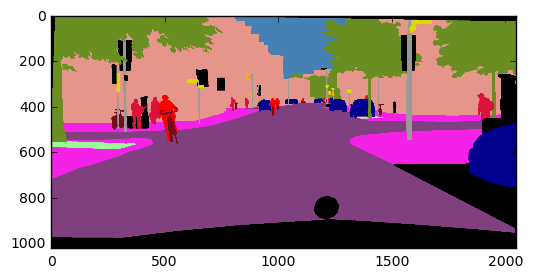

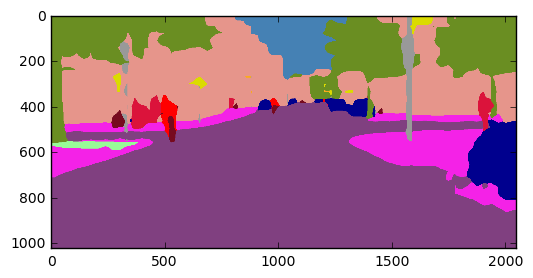

1499

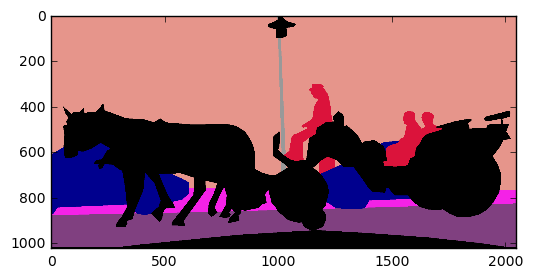

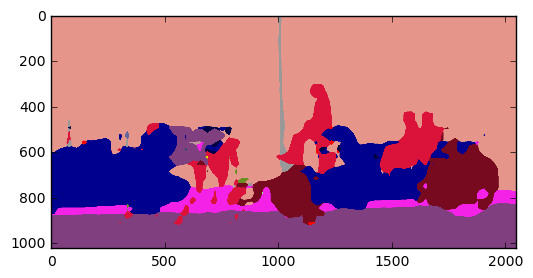

1999

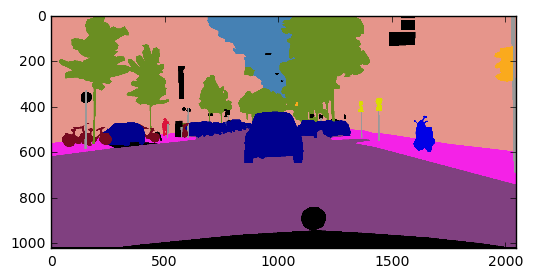

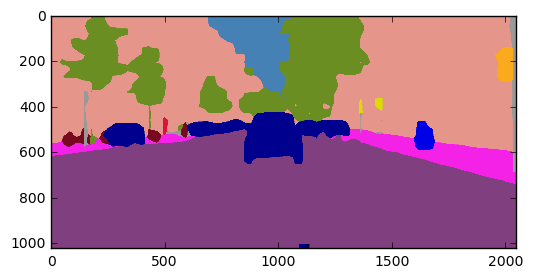

2369requesting stop


KeyboardInterrupt: 

In [3]:
total_train_loss_list,train_loss_list,plot_train_loss,plot_total_train_loss,plot_train_miou= [],[],[],[],[]
val_loss_list,plot_val_loss,plot_val_miou= [],[],[]
#for epoch in xrange(N_EPOCHS):
cmap = colors.ListedColormap([[0.4667,0.0431,0.1254],[0.902,0.5882,0.5490],[0,0.2353,0.3921]
                              ,[0,0,0.5569],[0.7451,0.6,0.6],[0,0,0.902]
                              ,[0.8627,0.0784,0.2352],[0.6,0.6,0.6],[1,0,0]
                              ,[0.502,0.251,0.502],[0.9569,0.1372,0.9098],[0.2745,0.5098,0.7059]
                              ,[0.5961,0.9843,0.5961],[0.9804,0.6667,0.1176],[0.8627,0.8627,0]
                              ,[0,0.3137,0.3922],[0,0,0.2745],[0.4196,0.5569,0.1372]
                              ,[0.4,0.4,0.6118],[0,0,0]])
norm=colors.NoNorm(0,19)
try:
    while not coord.should_stop() and epoch< N_EPOCHS:
        epoch+=1
        epoch_start_time = time.time()
        for iteration in xrange(2975/BATCH_SIZE): 
            if (iteration%500==0):
                _,train_loss,total_train_loss,_,train_pred_pic, train_label_pic = sess.run([train_op,cross_entropy_mean,total_loss,
                                                            update_cm,vgg_fcn.pred_up,labels_tf],feed_dict={train_mode: True})
                plt.figure(1)
                plt.imshow(train_label_pic[0],cmap=cmap,norm=norm)
                plt.figure(2)
                plt.imshow(train_pred_pic[0],cmap=cmap,norm=norm)
                #plt.figure(3)
                #plt.imshow(output2[0],cmap=cmap,norm=norm)
                plt.show()
            else:
                    _,train_loss,total_train_loss,_ = sess.run([train_op,cross_entropy_mean,total_loss,
                                                            update_cm],feed_dict={train_mode: True})
            train_loss_list.append(train_loss)
            total_train_loss_list.append(total_train_loss)
            sys.stdout.write('\r\r' + str(iteration))
            sys.stdout.flush()
                

        train_iou=sess.run(miou)
        train_loss_mean = np.mean(train_loss_list)
        total_train_loss_mean=np.mean(total_train_loss_list)
        plot_train_loss.append(train_loss_mean)
        plot_total_train_loss.append(total_train_loss_mean)

        train_loss_list = []
        total_train_loss_list = []
        plot_train_miou.append(train_iou)
        
        var_miou = filter(lambda x: x.name.endswith('total_confusion_matrix:0'), tf.local_variables())
        init_miou=tf.initialize_variables(var_miou)
        sess.run(init_miou)
        
        
        
        for iteration in xrange(500/BATCH_SIZE): 
            if (iteration%100==0):
                val_loss,_,val_pred_pic, val_label_pic = sess.run([cross_entropy_mean,
                                                            update_cm,vgg_fcn.pred_up,labels_tf],feed_dict={train_mode: False})
                plt.figure(1)
                plt.imshow(val_label_pic[0],cmap=cmap,norm=norm)
                plt.figure(2)
                plt.imshow(val_pred_pic[0],cmap=cmap,norm=norm)
                #plt.figure(3)
                #plt.imshow(output2[0],cmap=cmap,norm=norm)
                plt.show()
            else:
                    val_loss,_ = sess.run([cross_entropy_mean,update_cm],feed_dict={train_mode: False})
            val_loss_list.append(val_loss)
            sys.stdout.write('\r\r' + str(iteration))
            sys.stdout.flush()
            
        val_iou=sess.run(miou)
        val_loss_mean = np.mean(val_loss_list)
        plot_val_loss.append(val_loss_mean)
        
        val_loss_list = []
        plot_val_miou.append(val_iou)
        
        var_miou = filter(lambda x: x.name.endswith('total_confusion_matrix:0'), tf.local_variables())
        init_miou=tf.initialize_variables(var_miou)
        sess.run(init_miou)
        
        clear_output()
        print "Epoch", epoch
        
        print "===========**Training ACCURACY**================"
        print 'Training mIOU: ', train_iou
        print "Training Loss:", train_loss_mean 
        print "Training Loss:", total_train_loss_mean 
        
        print "===========**VALIDATION ACCURACY**================"
        print 'Validation mIOU: ', val_iou
        print "Validation Loss:", val_loss_mean 
        
        print "=================**TIME**===================="
        print 'Time Elapsed for Epoch:' + str(epoch) + ' is ' + str(
                (time.time() - epoch_start_time) / 60.) + ' minutes'
        
        plt.figure(1) 
        dd = plt.plot(plot_total_train_loss,'r',label="Training")
        plt.title("Total LOSS")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.figure(2) 
        aa = plt.plot(plot_train_loss,'r',label="Training")
        aav = plt.plot(plot_val_loss,'g',label="Validation")
        plt.title("LOSS")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.figure(3)
        cc = plt.plot(plot_train_miou,'r',label="Training")
        aav = plt.plot(plot_val_miou,'g',label="Validation")
        plt.title("mIOU")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        saver.save(sess, ckpt_dir, global_step=epoch)
        ofile  = open(data_csv_path, "a")
        writer = csv.writer(ofile)
        timep=((time.time() - epoch_start_time) / 60.)
        writer.writerow([train_loss_mean,train_iou,timep,val_loss_mean,val_iou,epoch])
        ofile.close()
except tf.errors.OutOfRangeError:
    print ("out of range")
finally:
    coord.request_stop()
    coord.join(threads)
    print("requesting stop")
        #print(iou[1])
            #train_loss= sess.run(vgg_fcn.upscore,
             #   feed_dict={ images_tf: train_imbatch})
            #res=sess.run(image)
            #plt.imshow(train_labatch[0])
            #plt.show()
    #    aa= tt * np.log10(train_loss)
    #    print(len(aa))
    #    print(len(aa[0]))
    #print(sum)
    #print(sum2)
    #print(len(ww))
    #print(len(ww[0]))
    #print(len(ww[0][0]))


